In [12]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [41]:
preprocessed_path = "done_data.csv"
if os.path.exists(preprocessed_path):
    data = pd.read_csv(preprocessed_path, index_col=0)
else:
    data = preprocess_data()
    data = add_turbulence(data)
    data.to_csv(preprocessed_path)

print(data.head())
print(data.size)

   datadate   tic      adjcp       open       high        low      volume  \
0  20090102  AAPL  12.964286  12.268571  13.005714  12.165714  26641980.0   
1  20090102   AXP  19.330000  18.570000  19.520000  18.400000  10955620.0   
2  20090102    BA  45.250000  42.800000  45.560000  42.780000   7010171.0   
3  20090102   CAT  46.910000  44.910000  46.980000  44.710000   7116726.0   
4  20090102  CSCO  16.960000  16.410000  17.000000  16.250000  40977480.0   

   macd    rsi        cci    adx  turbulence  
0   0.0  100.0  66.666667  100.0         0.0  
1   0.0  100.0  66.666667  100.0         0.0  
2   0.0  100.0  66.666667  100.0         0.0  
3   0.0    0.0  66.666667  100.0         0.0  
4   0.0  100.0  66.666667  100.0         0.0  
1053360


In [14]:
data['formatteddate'] = pd.to_datetime(data['datadate'], format='%Y%m%d', errors='coerce')
print(data.head())

   datadate   tic      adjcp       open       high        low      volume  \
0  20090102  AAPL  12.964286  12.268571  13.005714  12.165714  26641980.0   
1  20090102   AXP  19.330000  18.570000  19.520000  18.400000  10955620.0   
2  20090102    BA  45.250000  42.800000  45.560000  42.780000   7010171.0   
3  20090102   CAT  46.910000  44.910000  46.980000  44.710000   7116726.0   
4  20090102  CSCO  16.960000  16.410000  17.000000  16.250000  40977480.0   

   macd    rsi        cci    adx  turbulence formatteddate  
0   0.0  100.0  66.666667  100.0         0.0    2009-01-02  
1   0.0  100.0  66.666667  100.0         0.0    2009-01-02  
2   0.0  100.0  66.666667  100.0         0.0    2009-01-02  
3   0.0    0.0  66.666667  100.0         0.0    2009-01-02  
4   0.0  100.0  66.666667  100.0         0.0    2009-01-02  


In [150]:
# df_grouped = data.groupby(['formatteddate', 'tic']).first()
# print(df_grouped.head())

# Data visualization

In [20]:
# number of stocks
data.tic.unique().shape

(30,)

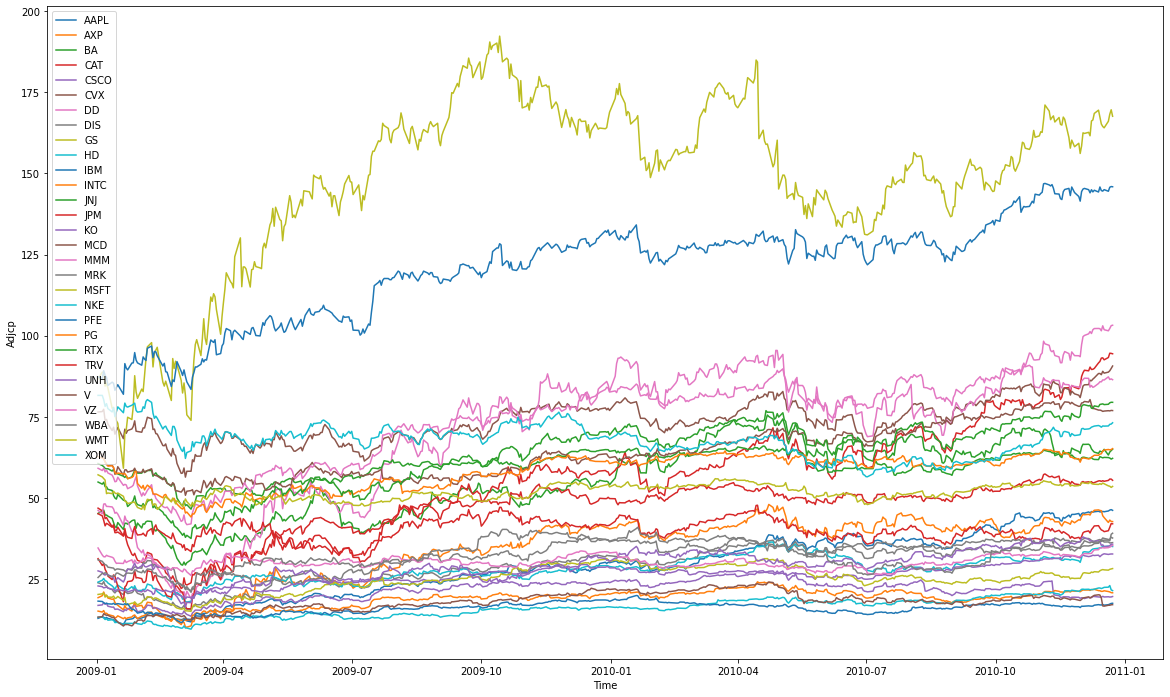

In [415]:
df_plot = data[data['formatteddate'] <= '2010-12-23']

plt.figure(figsize=(20,12))

for t in data.tic.unique():
    plt.plot(df_plot[df_plot['tic'] == t]['formatteddate'], df_plot[df_plot['tic'] == t]['adjcp'], label = t)
plt.legend()
plt.ylabel('Adjcp')
plt.xlabel('Time')

plt.show()

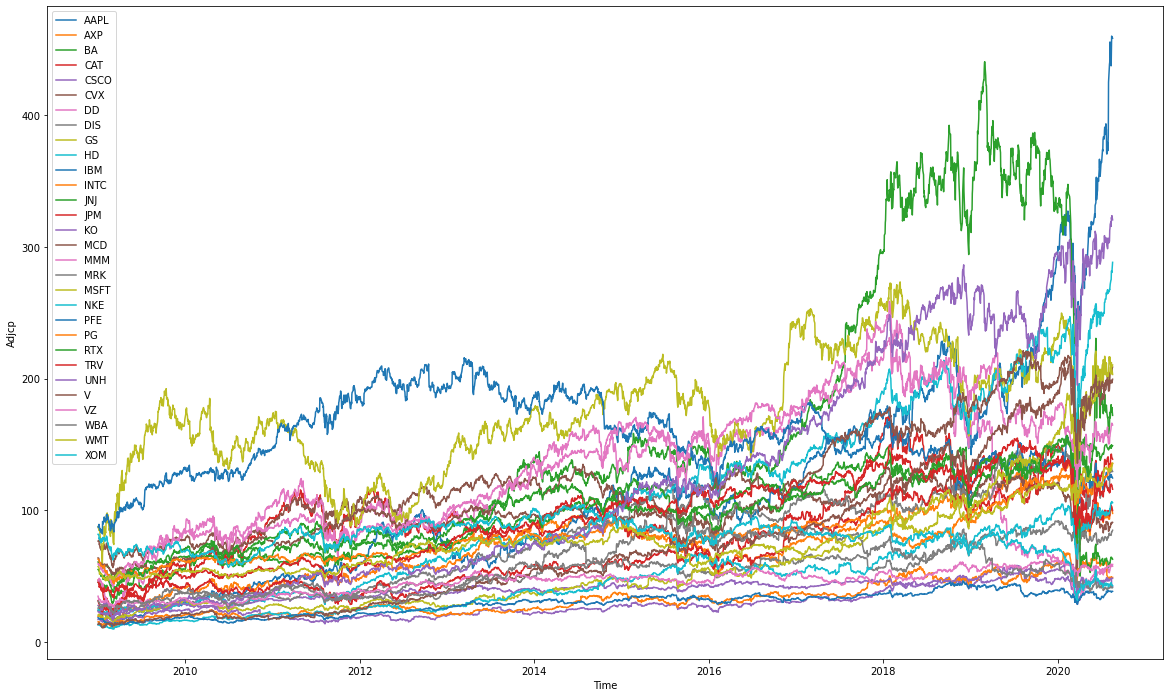

In [4]:
df_plot = data

plt.figure(figsize=(20,12))

for t in data.tic.unique():
    plt.plot(df_plot[df_plot['tic'] == t]['formatteddate'], df_plot[df_plot['tic'] == t]['adjcp'], label = t)
plt.legend()
plt.ylabel('Adjcp')
plt.xlabel('Time')

plt.show()

In [10]:
# Overall return over time
init_df = data[data['datadate']==20090102]
end_df = data[data['datadate']==20101223]
overall_return_df = (end_df['adjcp'].reset_index() - init_df['adjcp'].reset_index()) / init_df['adjcp'].reset_index()
overall_return = overall_return_df.mean()
print(overall_return)

index       inf
adjcp    0.4704
dtype: float64


# Model    

In [15]:
arms = ['BH', 'EW', 'VW']
start = 120
cycle = 500
warmup = 2
numberOfStock = data.tic.unique().shape[0]
c = 1

In [16]:
class stock_bandit:
    def __init__(self, arms = None, prior = None):
        self.alpha = np.zeros((len(arms),), dtype = int)
        self.beta = np.zeros_like(self.alpha)
        self.arms = arms
        if prior is None:
            self.prior = [(1.0,1.0) for i in range(len(arms))]
        else:
            self.prior = prior

    def add_data(self, arm_num, success):
        if success:
            self.alpha[arm_num]+=1
        else:
            self.beta[arm_num]+=1

    def sample(self):
        posterior_sample = np.zeros(len(self.arms))
        for i in range(len(self.arms)):			
            a = self.prior[i][0]+ self.alpha[i]
            b = self.prior[i][1] + self.beta[i]
            posterior_sample[i] = np.random.beta(a,b)
        return np.argmax(posterior_sample)
    
    def get_distr(self):
        params = []
        for i in range(len(self.arms)):			
            a = self.prior[i][0]+ self.alpha[i]
            b = self.prior[i][1] + self.beta[i]
            params.append([a,b])
        return params

In [17]:
def calculate_weight(armIndex, df_returnWeight, numberOfStock):
    if armIndex == 0:
        #arm one weight unchanged from last
        newWeight = df_returnWeight['weight'].iloc[-1]
    elif armIndex == 1:
        #arm three average weight for all stocks
        newWeight = np.ones((numberOfStock,), dtype = int) / numberOfStock
    elif armIndex == 2:
        #arm four value weighted profilo
        numerator = df_returnWeight['weight'].iloc[-1] * df_returnWeight['r'].iloc[-1]
        newWeight = numerator / numerator.sum()
        
    return newWeight

In [18]:
def calculate_return(index, data):
    newPrice = data[data['formatteddate'] == data['formatteddate'].unique()[index]].adjcp
    newPrice.reset_index(drop=True, inplace=True)
    oldPrice = data[data['formatteddate'] == data['formatteddate'].unique()[index - 1]].adjcp
    oldPrice.reset_index(drop=True, inplace=True)
    net = newPrice - oldPrice
    return net / oldPrice

In [19]:
def calculate_return_origin(index, data):
    newPrice = data[data['formatteddate'] == data['formatteddate'].unique()[index]].adjcp
    newPrice.reset_index(drop=True, inplace=True)
    oldPrice = data[data['formatteddate'] == data['formatteddate'].unique()[index - 1]].adjcp
    oldPrice.reset_index(drop=True, inplace=True)
    return newPrice / oldPrice

In [20]:
def calculate_sharpe(df_returnWeight):
    mean = df_returnWeight['r'].iloc[-1].mean()
    variance = df_returnWeight['r'].iloc[-1].std()
    sharpe = mean / variance
    return sharpe

In [21]:
def calculate_sharpe_origin(df_returnWeight, count):
    ut = df_returnWeight['weight'].iloc[-1] * df_returnWeight['r'].iloc[-1] - 1
    u = ut.sum() / count
    var = np.sqrt(((ut - u)**2).sum()/count)
    sharpe = u / var
    return sharpe

In [22]:
def calculate_wealth(df_returnWeight):
    rw = df_returnWeight['weight'].iloc[-1] * df_returnWeight['r'].iloc[-1]
    return rw.sum()

In [23]:
def calculate_cwealth(df_returnWeight):
    sum = 0
    for i in range(df_returnWeight.shape[0]):
        rw = df_returnWeight['weight'].iloc[i] * df_returnWeight['r'].iloc[i]
        sum = rw.sum() + sum
    return sum

In [24]:
def calculate_origin_cwealth(df_returnWeight):
    sum = 1
    for i in range(df_returnWeight.shape[0]):
        rw = (df_returnWeight['weight'].iloc[i] * df_returnWeight['r'].iloc[i]).sum()
        sum *= rw
    return sum

# Sold All

In [358]:
# dWeight2 = np.ones((numberOfStock,), dtype = int) / numberOfStock
# dReturn2 = calculate_return(1, data)
# df_returnWeight2 = pd.DataFrame({'weight': [dWeight], 'r': [dReturn]})
# pre_cw2 = 0
# cw2 = 0
# for k in range(warmup, cycle):
#     #calcuate new weight for arm
#     newWeight = calculate_weight(1, df_returnWeight2, numberOfStock)
#     #calcuate new return for arm
#     newReturn = calculate_return(k, data)

#     df2 = pd.DataFrame({'weight': [newWeight], 'r': [newReturn]})
#     df_returnWeight1 = df_returnWeight2.append(df2, ignore_index = True)

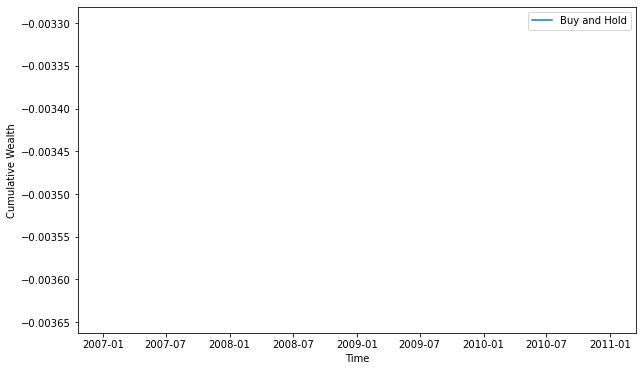

In [359]:
# plt.figure(figsize=(10,6))
# suma2 = []
# datea2 = []
# for i in range(df_returnWeight2.shape[0]):
#     sum = (df_returnWeight2['weight'].iloc[i] * df_returnWeight2['r'].iloc[i]).sum()
#     suma2.append(sum)
#     datea2.append(data['formatteddate'].unique()[i])
# df_cr2 = pd.DataFrame({'datea': datea2, 'suma': suma2})
# plt.plot(df_cr2['datea'], df_cr2['suma'], label='Buy and Hold')
# plt.legend()
# plt.ylabel('Cumulative Wealth')
# plt.xlabel('Time')

# plt.show()
# # Since it's always sold, obviously there won't be any cumulative wealth

In [364]:
# df_cr2['suma'].iloc[-1].sum()

-0.0034715215833357104

# Equally-weighted portfolio only

In [25]:
dWeight3 = np.ones((numberOfStock,), dtype = int) / numberOfStock
dReturn3 = calculate_return_origin(1, data)
df_returnWeight3 = pd.DataFrame({'weight': [dWeight3], 'r': [dReturn3]})

for k in range(warmup, cycle):
    #calcuate new weight for arm
    newWeight = calculate_weight(1, df_returnWeight3, numberOfStock)
    #calcuate new return for arm
    newReturn = calculate_return_origin(k, data)
    df2 = pd.DataFrame({'weight': [newWeight], 'r': [newReturn]})
    df_returnWeight3 = df_returnWeight3.append(df2, ignore_index = True)

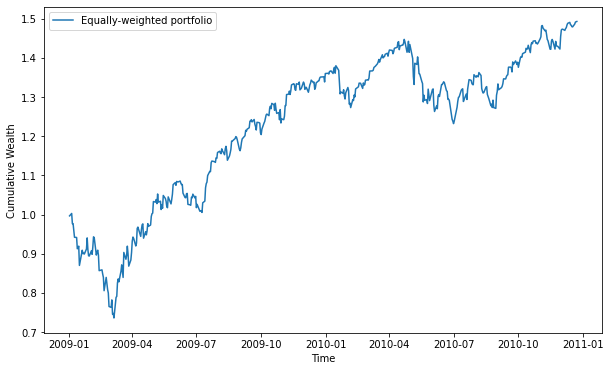

In [26]:
plt.figure(figsize=(10,6))
suma3 = []
datea3 = []
for i in range(df_returnWeight3.shape[0]):
    sum = (df_returnWeight3['weight'].iloc[i] * df_returnWeight3['r'].iloc[i]).sum()
    if (i != 0):
        sum *= suma3[len(suma3) -1]
    suma3.append(sum)
    datea3.append(data['formatteddate'].unique()[i])
df_cr3 = pd.DataFrame({'datea': datea3, 'suma': suma3})
plt.plot(df_cr3['datea'], df_cr3['suma'], label='Equally-weighted portfolio')
plt.legend()
plt.ylabel('Cumulative Wealth')
plt.xlabel('Time')

plt.show()

In [27]:
df_cr3['suma'].iloc[-1]

1.4929528583236007

# Value-weighted portfolio

In [28]:
dWeight4 = np.ones((numberOfStock,), dtype = int) / numberOfStock
dReturn4 = calculate_return_origin(1, data)
df_returnWeight4 = pd.DataFrame({'weight': [dWeight4], 'r': [dReturn4]})

for k in range(warmup, cycle):
    #calcuate new weight for arm
    newWeight = calculate_weight(2, df_returnWeight4, numberOfStock)
    #calcuate new return for arm
    newReturn = calculate_return_origin(k, data)

    df2 = pd.DataFrame({'weight': [newWeight], 'r': [newReturn]})
    df_returnWeight4 = df_returnWeight4.append(df2, ignore_index = True)

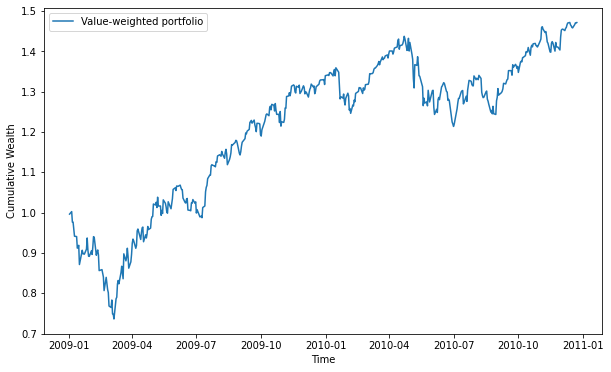

In [29]:
plt.figure(figsize=(10,6))
suma4 = []
datea4 = []
for i in range(df_returnWeight4.shape[0]):
    sum = (df_returnWeight4['weight'].iloc[i] * df_returnWeight4['r'].iloc[i]).sum()
    if (i != 0):
        sum *= suma4[len(suma4) -1]
    suma4.append(sum)
    datea4.append(data['formatteddate'].unique()[i])
df_cr4 = pd.DataFrame({'datea': datea4, 'suma': suma4})
plt.plot(df_cr4['datea'], df_cr4['suma'], label='Value-weighted portfolio')
plt.legend()
plt.ylabel('Cumulative Wealth')
plt.xlabel('Time')

plt.show()

In [30]:
df_cr4['suma'].iloc[-1]

1.4716133571608518

# beta with sharpe ratio

In [427]:
# #init a new stock bandit with no prior
# bandit = stock_bandit(arms)
# selectedArms = []
# #use 1 set of data to set the first buy as equal weight for all stocks
# dWeight = np.ones((numberOfStock,), dtype = int) / numberOfStock
# dReturn = calculate_return(1, data)
# df_returnWeight = pd.DataFrame({'weight': [dWeight], 'r': [dReturn]})
# pre_sharpe = 0
# sharpe = 0

# for k in range(warmup, cycle):
#     if sharpe != None:
#         pre_sharpe = sharpe
#     #sample from distribution
#     selected = bandit.sample()
#     selectedArms.append(selected)
#     #calcuate new weight for arm
#     newWeight = calculate_weight(selected, df_returnWeight, numberOfStock)
#     #calcuate new return for arm
#     newReturn = calculate_return(k, data)
#     #calcualte old sharpe ratio
#     sharpe = calculate_sharpe(df_returnWeight)

#     df2 = pd.DataFrame({'weight': [newWeight], 'r': [newReturn]})
#     df_returnWeight = df_returnWeight.append(df2, ignore_index = True)
    
#     if sharpe > pre_sharpe:
#         bandit.add_data(selected, True)
#     else:
#         bandit.add_data(selected, False)

In [428]:
# bandit.get_distr()

[[110.0, 108.0], [73.0, 85.0], [50.0, 62.0], [5.0, 13.0]]

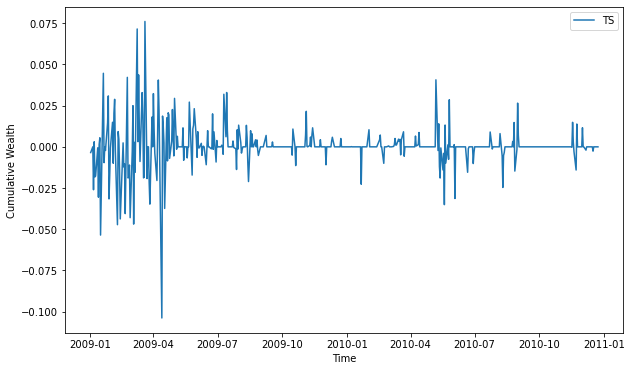

In [429]:
# plt.figure(figsize=(10,6))
# suma = []
# datea = []
# for i in range(df_returnWeight.shape[0]):
#     sum = (df_returnWeight['weight'].iloc[i] * df_returnWeight['r'].iloc[i]).sum()
#     suma.append(sum)
#     datea.append(data['formatteddate'].unique()[i])
# df_cr = pd.DataFrame({'datea': datea, 'suma': suma})
# plt.plot(df_cr['datea'], df_cr['suma'], label='TS')
# plt.legend()
# plt.ylabel('Cumulative Wealth')
# plt.xlabel('Time')

# plt.show()

# beta with cumulative wealth

In [36]:
#init a new stock bandit with no prior
bandit = stock_bandit(arms)
selectedArms = []
#use 1 set of data to set the first buy as equal weight for all stocks
dWeight = np.ones((numberOfStock,), dtype = int) / numberOfStock
dReturn = calculate_return_origin(1, data)
df_returnWeight = pd.DataFrame({'weight': [dWeight], 'r': [dReturn]})
pre_cw = 0
cw = 0

for k in range(warmup, cycle):
    #sample from distribution
    selected = bandit.sample()
    selectedArms.append(selected)
    #calcuate new weight for arm
    newWeight = calculate_weight(selected, df_returnWeight, numberOfStock)
    #calcuate new return for arm
    newReturn = calculate_return_origin(k, data)
    #calcualte cw
    cw = calculate_origin_cwealth(df_returnWeight)

    df2 = pd.DataFrame({'weight': [newWeight], 'r': [newReturn]})
    df_returnWeight = df_returnWeight.append(df2, ignore_index = True)
    pre_cw = cw
    cw = calculate_origin_cwealth(df_returnWeight)

    if cw  > pre_cw: #c:
        bandit.add_data(selected, True)
    else:
        bandit.add_data(selected, False)

In [37]:
bandit.get_distr()

[[176.0, 128.0], [72.0, 62.0], [36.0, 30.0]]

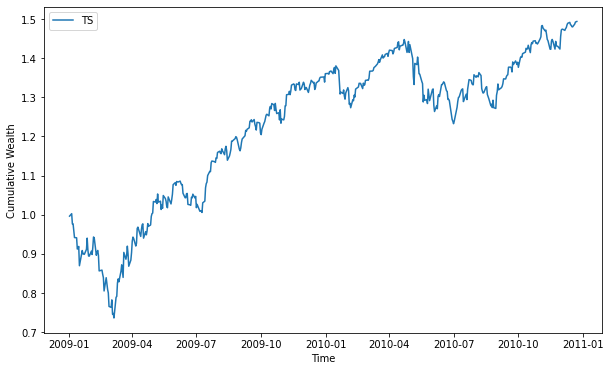

In [38]:
plt.figure(figsize=(10,6))
suma = []
datea = []
for i in range(df_returnWeight.shape[0]):
    sum = (df_returnWeight['weight'].iloc[i] * df_returnWeight['r'].iloc[i]).sum()
    if (i != 0):
        sum *= suma[len(suma) -1]
    suma.append(sum)
    datea.append(data['formatteddate'].unique()[i])
df_cr = pd.DataFrame({'datea': datea, 'suma': suma})
plt.plot(df_cr['datea'], df_cr['suma'], label='TS')
plt.legend()
plt.ylabel('Cumulative Wealth')
plt.xlabel('Time')

plt.show()

In [39]:
df_cr['suma'].iloc[-1]

1.4935691327827056

In [45]:
result_path = 'account_value_train.csv'
ppo_result = pd.read_csv(result_path, index_col=0)

In [59]:
df_date_ppo = df_cr['datea'].drop(df_cr.tail(1).index)
ppo_result['datea'] = df_date_ppo
ppo_result.columns = ['suma','datea']
ppo_result['suma'] = ppo_result['suma'] / 1000000

Text(0.5, 0, 'Time')

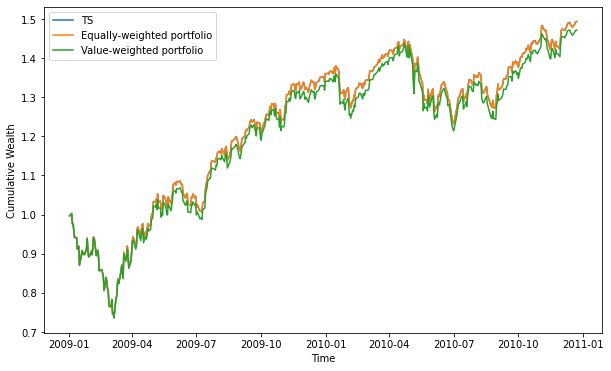

In [61]:
plt.figure(figsize=(10,6))
plt.plot(df_cr['datea'], df_cr['suma'], label='TS')
plt.plot(df_cr3['datea'], df_cr3['suma'], label='Equally-weighted portfolio')
plt.plot(df_cr4['datea'], df_cr4['suma'], label='Value-weighted portfolio')
# plt.plot(ppo_result['datea'], ppo_result['suma'], label='PPO')
plt.legend()
plt.ylabel('Cumulative Wealth')
plt.xlabel('Time')